In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.isophote import EllipseGeometry, Ellipse

# Bring these later when you fit & derive totals:
# from scipy.optimize import curve_fit
# from scipy.special import gamma

# Optional, import *inside* the display cell only if used:
# from astropy.visualization import ZScaleInterval, ImageNormalize
# from photutils.segmentation import detect_threshold, detect_sources


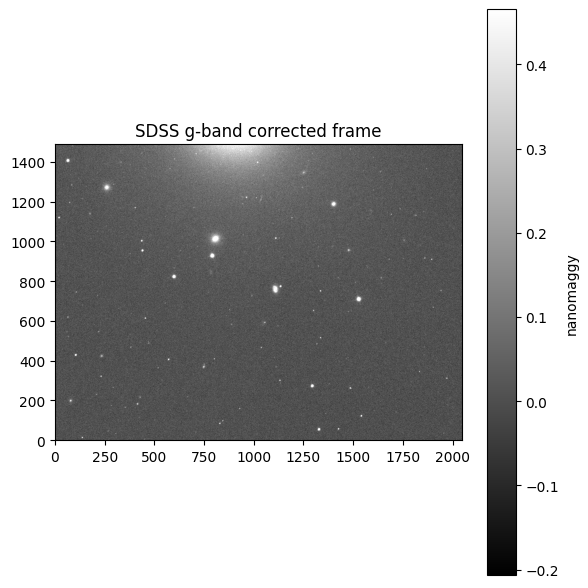

In [2]:
from astropy.visualization import ZScaleInterval, ImageNormalize  # local import for this cell only

# load data + header
img = fits.getdata("C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/frame-g-002168-5-0147.fits").astype(np.float32)
hdr = fits.getheader("C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/frame-g-002168-5-0147.fits")

# optional: pull units for labeling if available
bunit = hdr.get('BUNIT', 'flux per pixel')

# quick display with zscale
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.figure(figsize=(6, 6))
plt.imshow(img, origin='lower', cmap='gray', norm=norm)
plt.title("SDSS g-band corrected frame")
plt.colorbar(label=bunit)
plt.tight_layout()
plt.show()


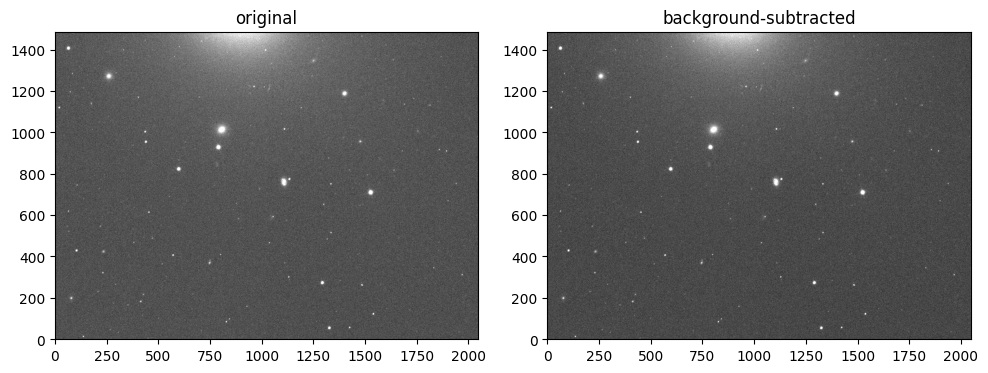

In [3]:
# Robust constant background via sigma clipping (minimal, no SEP)
bkg_mean, bkg_median, bkg_rms = sigma_clipped_stats(img, sigma=3.0, maxiters=5)
img_sub = img - bkg_median  # do not mutate img; keep both around

# Quick look (two panels is enough for the pipeline)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img, origin='lower', cmap='gray', norm=norm)
axes[0].set_title('original')
axes[1].imshow(img_sub, origin='lower', cmap='gray', norm=norm)
axes[1].set_title('background-subtracted')
plt.tight_layout()
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_15012\522753652.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  xy = plt.ginput(1, timeout=0)


KeyboardInterrupt: 

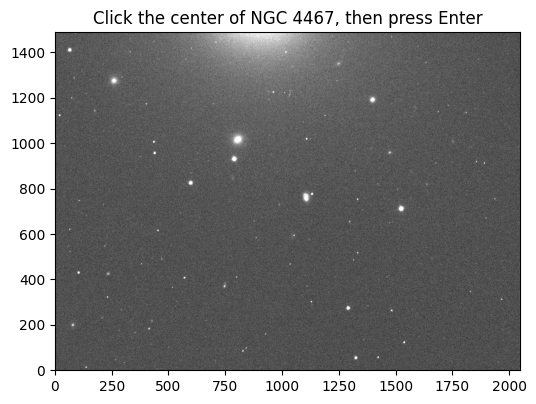

In [49]:
from astropy.visualization import ZScaleInterval, ImageNormalize

fig, ax = plt.subplots(figsize=(6,6))
norm = ImageNormalize(img - np.nanmedian(img), interval=ZScaleInterval())
ax.imshow(img - np.nanmedian(img), origin='lower', cmap='gray', norm=norm)
ax.set_title('Click the center of NGC 4467, then press Enter')
xy = plt.ginput(1, timeout=0)
plt.close(fig)

x0, y0 = float(xy[0][0]), float(xy[0][1])
print(f"Selected center: x={x0:.1f}, y={y0:.1f}")

# keep simple ellipse geometry; or reuse your previous q, theta
q, theta = 0.8, 0.0


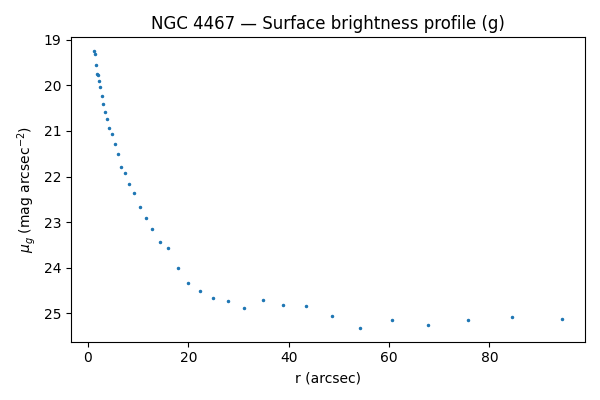

In [5]:
# === CELL A (minimal): background, manual center, annulus sampling ===
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.aperture import EllipticalAnnulus
import matplotlib.pyplot as plt

# 1) background & background-subtracted image
bkg_mean, bkg_median, bkg_rms = sigma_clipped_stats(img, sigma=3.0, maxiters=5)
img_sub = img - bkg_median

# 2) manual galaxy center (from your zoom)
x0, y0 = 805.0, 1012.0   # pixels for NGC 4467

# 3) fixed ellipse geometry (simple & robust)
s = 0.396        # arcsec/pixel
q = 0.85         # axis ratio b/a (modest ellipticity)
theta = 0.0      # position angle in radians

# 4) radial grid (start just beyond 1", stop before the image edge or ~100")
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))                  # > 1"
r_edge    = int(min(x0, y0, (w - 1) - x0, (h - 1) - y0))   # nearest border
r_max_pix = max(r_min_pix + 3, min(int(np.floor(100.0 / s)), r_edge - 3))

nbins = 40  # fatter annuli -> better S/N
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints (pixels)

# 5) sample mean intensity per annulus with light clip against stellar spikes
intens_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,   # NOTE: b_out > b_in
        theta=theta
    )
    am = ann.to_mask(method='center')
    am = am[0] if isinstance(am, list) else am

    cut = am.cutout(img_sub)
    if cut is None:
        intens_pix.append(np.nan)
        continue

    vals = cut[am.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        intens_pix.append(np.nan)
        continue

    # trim top 5% to suppress stars/cosmic rays
    hi = np.nanpercentile(vals, 95.0)
    vals = vals[vals <= hi]

    intens_pix.append(float(np.nanmedian(vals)))   # nMgy / pixel

intens_pix = np.asarray(intens_pix, dtype=float)
good = np.isfinite(intens_pix) & (intens_pix > 0)
sma_pix = sma_pix[good]
intens_pix = intens_pix[good]

# 6) convert to SB in mag/arcsec^2
r_arcsec = sma_pix * s
I_as2 = intens_pix / (s**2)                # nMgy / arcsec^2
mu = 22.5 - 2.5 * np.log10(I_as2)

# quick look
plt.figure(figsize=(6, 4))
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu_g$ (mag arcsec$^{-2}$)')
plt.title('NGC 4467 — Surface brightness profile (g)')
plt.tight_layout(); plt.show()


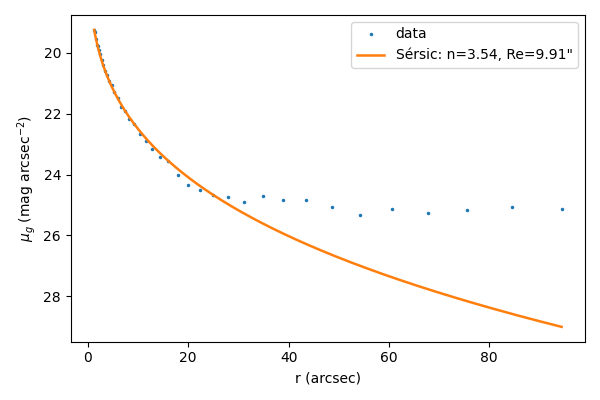

In [7]:
# === MINIMAL CORE: B. Sérsic fit in linear units & overlay ===
from scipy.optimize import curve_fit

def b_n(n):
    return 2*n - 1/3 + 4/(405*n) + 46/(25515*n*n)

def sersic_I(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r/Re)**(1/n) - 1))

# fit points: beyond 1"
mfit = (r_arcsec > 1.0) & np.isfinite(I_as2) & (I_as2 > 0)
x = r_arcsec[mfit]; y = I_as2[mfit]
if x.size < 8:
    raise RuntimeError("Not enough points to fit. Reduce clipping or nbins slightly.")

# simple initial guesses & bounds tied to your data extent
p0 = (float(np.nanmedian(y)), float(np.nanmedian(x)), 3.0)
Re_max = max(1.0, float(np.nanmax(x))*1.2)
lb = (max(1e-12, 0.1*np.nanmin(y)), 0.2, 0.3)
ub = (10*np.nanmax(y), Re_max, 8.0)

popt, pcov = curve_fit(sersic_I, x, y, p0=p0, bounds=(lb, ub), maxfev=50000)
Ie, Re_fit, n_fit = popt
mu_e_fit = 22.5 - 2.5*np.log10(Ie)

# overlay in μ-space
xx = np.linspace(x.min(), x.max(), 400)
mu_model = 22.5 - 2.5*np.log10(sersic_I(xx, *popt))

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='data')
plt.plot(xx, mu_model, '-', lw=1.8, label=f'Sérsic: n={n_fit:.2f}, Re={Re_fit:.2f}"')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu_g$ (mag arcsec$^{-2}$)')
plt.legend(); plt.tight_layout(); plt.show()


In [8]:
# === MINIMAL CORE: C. derived quantities + magnitudes ===
from scipy.special import gamma

# required: effective SB, radius (arcsec & kpc), n, central SB
bn = b_n(n_fit)
mu0 = mu_e_fit - (2.5/np.log(10.0)) * bn

# distance for kpc conversion (YOU set this)
D_pc = 1.0e7   # <-- set your galaxy distance in parsecs
Re_kpc = (Re_fit * D_pc) / (206265.0 * 1e3)

print(f"mu_e (mag/arcsec^2): {mu_e_fit:.3f}")
print(f"R_e: {Re_fit:.3f}\"  = {Re_kpc:.3f} kpc")
print(f"n (Sérsic): {n_fit:.3f}")
print(f"mu_0 (central SB): {mu0:.3f} mag/arcsec^2")

# total apparent magnitude from Sérsic model (with axis ratio q)
F_tot_model = Ie * 2*np.pi * n_fit * (Re_fit**2) * q * np.exp(bn) * (bn**(-2*n_fit)) * gamma(2*n_fit)
m_app_model = 22.5 - 2.5*np.log10(F_tot_model)
print(f"Total apparent g magnitude (model): {m_app_model:.3f}")

from photutils.aperture import EllipticalAperture, aperture_photometry

# pick an outer semi-major axis near your last valid ring
r_ap = float(min(np.nanmax(sma_pix) * 1.1, r_max_pix))

# elliptical APERTURE (not annulus) with same q and theta as before
ap = EllipticalAperture((x0, y0), r_ap, q * r_ap, theta=theta)

# effective area (pixels), respecting the mask
area_eff = float(aperture_photometry(np.ones_like(img), ap, method='exact', mask=mask)['aperture_sum'][0])

# raw flux from the original image (not background-subtracted), then subtract bkg
flux_raw = float(aperture_photometry(img, ap, method='exact', mask=mask)['aperture_sum'][0])
flux_ap = flux_raw - bkg_median * area_eff

m_app_ap = 22.5 - 2.5 * np.log10(flux_ap) if (np.isfinite(flux_ap) and flux_ap > 0) else np.nan
print(f"Total apparent g magnitude (aperture): {m_app_ap}")



mu_e (mag/arcsec^2): 22.485
R_e: 9.914"  = 0.481 kpc
n (Sérsic): 3.540
mu_0 (central SB): 15.156 mag/arcsec^2
Total apparent g magnitude (model): 14.356


NameError: name 'mask' is not defined

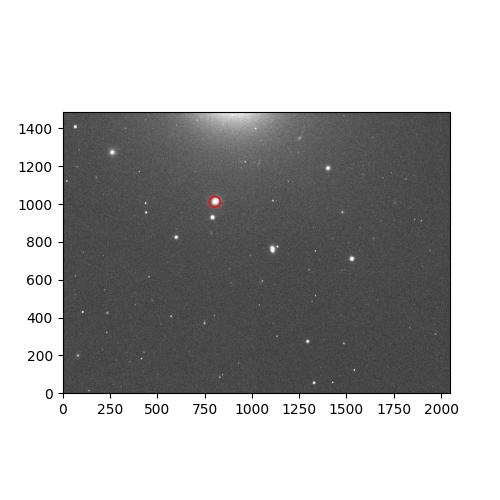

In [9]:
# %matplotlib widget
plt.figure(figsize=(5,5)); plt.imshow(img_sub, origin='lower', cmap='gray', norm=norm); plt.scatter([x0],[y0], s=60, facecolors='none', edgecolors='r'); plt.show()

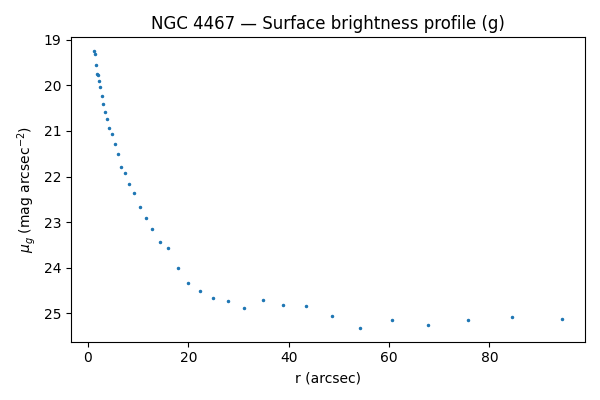

In [10]:
# === CELL A: background, manual center, annulus sampling ===
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.aperture import EllipticalAnnulus
import matplotlib.pyplot as plt

# 1) background & background-subtracted image
bkg_mean, bkg_median, bkg_rms = sigma_clipped_stats(img, sigma=3.0, maxiters=5)
img_sub = img - bkg_median

# 2) manual galaxy center (from your zoom)
x0, y0 = 805.0, 1012.0   # pixels for NGC 4467

# 3) fixed ellipse geometry (simple & robust)
s = 0.396        # arcsec/pixel
q = 0.85         # axis ratio b/a
theta = 0.0      # position angle [rad]

# 4) radial grid (start >1", stop before edge or ~100")
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))                  # > 1"
r_edge    = int(min(x0, y0, (w - 1) - x0, (h - 1) - y0))   # nearest border
r_max_pix = max(r_min_pix + 3, min(int(np.floor(100.0 / s)), r_edge - 3))

nbins = 40
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints (pixels)

# 5) mean intensity per annulus with light outlier trim
intens_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,   # NOTE: b_out > b_in
        theta=theta
    )
    am = ann.to_mask(method='center')
    am = am[0] if isinstance(am, list) else am

    cut = am.cutout(img_sub)
    if cut is None:
        intens_pix.append(np.nan); continue

    vals = cut[am.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        intens_pix.append(np.nan); continue

    hi = np.nanpercentile(vals, 95.0)       # suppress stellar spikes
    vals = vals[vals <= hi]
    intens_pix.append(float(np.nanmedian(vals)))   # nMgy / pixel

intens_pix = np.asarray(intens_pix, dtype=float)
good = np.isfinite(intens_pix) & (intens_pix > 0)
sma_pix = sma_pix[good]
intens_pix = intens_pix[good]

# 6) convert to SB in mag/arcsec^2
r_arcsec = sma_pix * s
I_as2 = intens_pix / (s**2)                # nMgy / arcsec^2
mu = 22.5 - 2.5 * np.log10(I_as2)

# quick look (standard orientation: brighter at top)
plt.figure(figsize=(6, 4))
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu_g$ (mag arcsec$^{-2}$)')
plt.title('NGC 4467 — Surface brightness profile (g)')
plt.tight_layout(); plt.show()


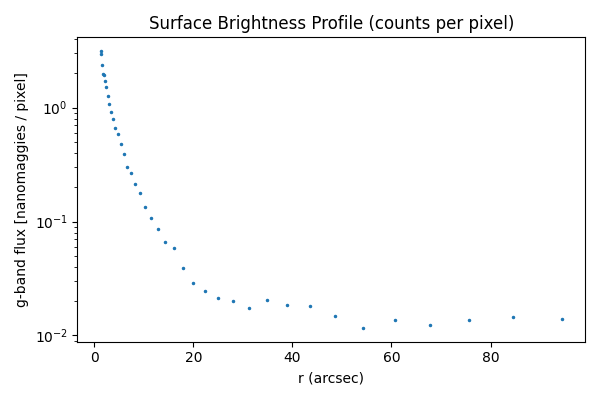

In [13]:
A_pix = s**2  # arcsec^2 per pixel, only needed if you also want per arcsec^2 later

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, intens_pix, '.', ms=3)
plt.yscale('log')  # optional but helpful, counts span orders of magnitude
plt.xlabel('r (arcsec)')
plt.ylabel('g-band flux [nanomaggies / pixel]')
plt.title('Surface Brightness Profile (counts per pixel)')
plt.tight_layout(); plt.show()


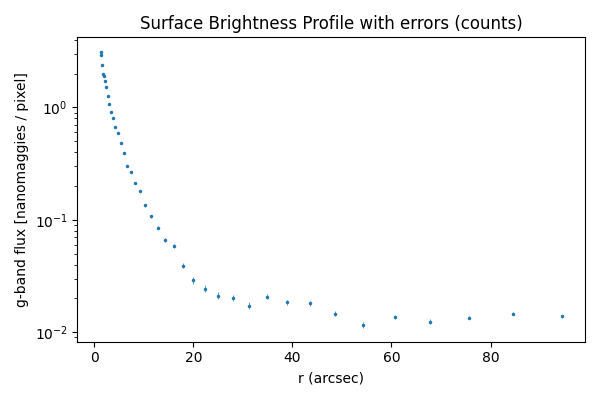

In [14]:
# annulus area (pixels) corresponding to each point
# If you used 'edges' to define bins and 'good' to filter them:
Npix_all = np.pi * q * (edges[1:]**2 - edges[:-1]**2)
Npix = Npix_all[good]

# S.E.M. of the mean ~ bkg_rms / sqrt(Npix)
ierr_counts = bkg_rms / np.sqrt(np.maximum(Npix, 1.0))

plt.figure(figsize=(6,4))
plt.errorbar(r_arcsec, intens_pix, yerr=ierr_counts, fmt='.', ms=3, lw=0.5)
plt.yscale('log')
plt.xlabel('r (arcsec)')
plt.ylabel('g-band flux [nanomaggies / pixel]')
plt.title('Surface Brightness Profile with errors (counts)')
plt.tight_layout(); plt.show()


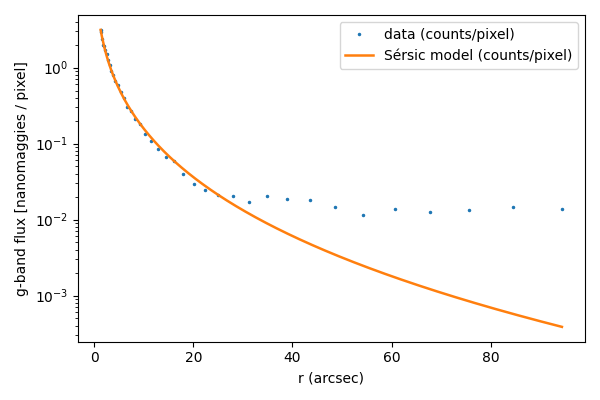

In [15]:
xx = np.linspace(r_arcsec.min(), r_arcsec.max(), 400)
I_model_as2 = sersic_I(xx, Ie, Re_fit, n_fit)     # nMgy / arcsec^2
I_model_pix = I_model_as2 * A_pix                 # nMgy / pixel

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, intens_pix, '.', ms=3, label='data (counts/pixel)')
plt.plot(xx, I_model_pix, '-', lw=1.8, label='Sérsic model (counts/pixel)')
plt.yscale('log')
plt.xlabel('r (arcsec)')
plt.ylabel('g-band flux [nanomaggies / pixel]')
plt.legend(); plt.tight_layout(); plt.show()


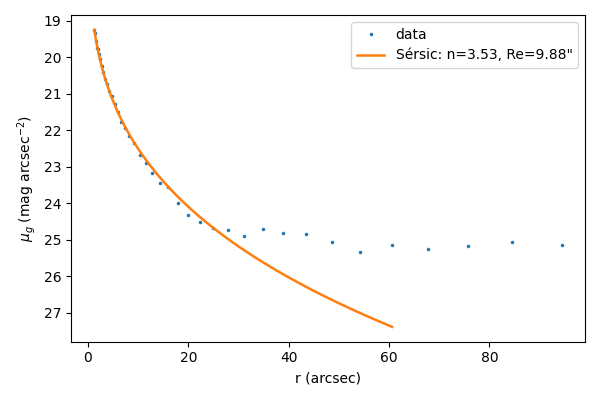

In [11]:
# === CELL B: S/N–gated Sérsic fit (linear units) + overlay ===
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def b_n(n):
    return 2*n - 1/3 + 4/(405*n) + 46/(25515*n*n)

def sersic_I(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r/Re)**(1/n) - 1))

# S/N per annulus for mean intensity: SNR ≈ I / (rms / sqrt(Npix))
Npix_all = np.pi * q * (edges[1:]**2 - edges[:-1]**2)  # ellipse area difference
Npix = Npix_all[good]                                  # align with 'good'
snr = I_as2 * (s**2) / (bkg_rms / np.sqrt(np.maximum(Npix, 1.0)))  # back to per-pixel I

# Fit only where data are reliable
fit_mask = (r_arcsec > 1.0) & (snr >= 3) & (r_arcsec < np.percentile(r_arcsec, 90))
x = r_arcsec[fit_mask]
y = I_as2[fit_mask]
if x.size < 8:
    fit_mask = (r_arcsec > 1.0) & (snr >= 2)  # relax slightly if needed
    x = r_arcsec[fit_mask]; y = I_as2[fit_mask]
if x.size < 8:
    raise RuntimeError("Not enough high-S/N points to fit; consider nbins=30 or a smaller clip.")

# Simple initial guesses & bounds tied to data extent
p0 = (float(np.nanmedian(y)), float(np.nanmedian(x)), 3.0)
Re_max = max(1.0, float(np.nanmax(x)) * 1.2)
lb = (max(1e-12, 0.1*np.nanmin(y)), 0.2, 0.3)
ub = (10*np.nanmax(y), Re_max, 8.0)

popt, pcov = curve_fit(sersic_I, x, y, p0=p0, bounds=(lb, ub), maxfev=50000)
Ie, Re_fit, n_fit = popt
mu_e_fit = 22.5 - 2.5*np.log10(Ie)

# overlay in μ-space
xx = np.linspace(x.min(), x.max(), 400)
mu_model = 22.5 - 2.5*np.log10(sersic_I(xx, *popt))

plt.figure(figsize=(6, 4))
plt.plot(r_arcsec, mu, '.', ms=3, label='data')
plt.plot(xx, mu_model, '-', lw=1.8, label=f'Sérsic: n={n_fit:.2f}, Re={Re_fit:.2f}\"')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu_g$ (mag arcsec$^{-2}$)')
plt.legend(); plt.tight_layout(); plt.show()


In [12]:
# === CELL C: derived quantities + total magnitudes ===
from scipy.special import gamma
from photutils.aperture import EllipticalAperture, aperture_photometry

# required: effective SB, radius (arcsec & kpc), n, central SB
bn = b_n(n_fit)
mu0 = mu_e_fit - (2.5/np.log(10.0)) * bn

# distance for kpc conversion (SET THIS)
D_pc = 16.5e6  # example: Virgo ~16.5 Mpc; replace with your adopted distance in parsecs
Re_kpc = (Re_fit * D_pc) / (206265.0 * 1e3)

print(f"mu_e (mag/arcsec^2): {mu_e_fit:.3f}")
print(f"R_e: {Re_fit:.3f}\"  = {Re_kpc:.3f} kpc")
print(f"n (Sérsic): {n_fit:.3f}")
print(f"mu_0 (central SB): {mu0:.3f} mag/arcsec^2")

# total apparent magnitude from Sérsic model (with axis ratio q)
F_tot_model = Ie * 2*np.pi * n_fit * (Re_fit**2) * q * np.exp(bn) * (bn**(-2*n_fit)) * gamma(2*n_fit)
m_app_model = 22.5 - 2.5*np.log10(F_tot_model)
print(f"Total apparent g magnitude (model): {m_app_model:.3f}")

# elliptical APERTURE sum as a cross-check (raw image minus background)
r_ap = float(min(r_max_pix, np.nanmax(sma_pix) * 1.1))
ap = EllipticalAperture((x0, y0), r_ap, q * r_ap, theta=theta)

area_eff = float(aperture_photometry(np.ones_like(img), ap, method='exact')['aperture_sum'][0])  # pixels
flux_raw = float(aperture_photometry(img, ap, method='exact')['aperture_sum'][0])               # raw counts (nMgy/pix)
flux_ap = flux_raw - bkg_median * area_eff                                                      # subtract background
m_app_ap = 22.5 - 2.5 * np.log10(flux_ap) if (np.isfinite(flux_ap) and flux_ap > 0) else np.nan
print(f"Total apparent g magnitude (aperture): {m_app_ap:.3f}")


mu_e (mag/arcsec^2): 22.479
R_e: 9.880"  = 0.790 kpc
n (Sérsic): 3.533
mu_0 (central SB): 15.166 mag/arcsec^2
Total apparent g magnitude (model): 14.358
Total apparent g magnitude (aperture): 12.758
